<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-configuration" data-toc-modified-id="Imports-and-configuration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and configuration</a></span></li><li><span><a href="#Load,-wrangle,-and-view-Data" data-toc-modified-id="Load,-wrangle,-and-view-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load, wrangle, and view Data</a></span></li><li><span><a href="#Setting-up-Host-Response-Model-(HRM)" data-toc-modified-id="Setting-up-Host-Response-Model-(HRM)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Setting up Host Response Model (HRM)</a></span><ul class="toc-item"><li><span><a href="#Embed-prior-network" data-toc-modified-id="Embed-prior-network-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Embed prior network</a></span></li><li><span><a href="#Map-genes-not-present-in-network-to-origin-(you-can-map-to-anywhere-in-RN)" data-toc-modified-id="Map-genes-not-present-in-network-to-origin-(you-can-map-to-anywhere-in-RN)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Map genes not present in network to origin (you can map to anywhere in RN)</a></span></li><li><span><a href="#Model-to-Drop-Genes-not-present-in-network-(this-means-you-will-not-get-predictions-for-genes-that-are-not-in-the-network)" data-toc-modified-id="Model-to-Drop-Genes-not-present-in-network-(this-means-you-will-not-get-predictions-for-genes-that-are-not-in-the-network)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Model to Drop Genes not present in network (this means you will not get predictions for genes that are not in the network)</a></span></li></ul></li><li><span><a href="#After-you-run-a-new-experiment-and-collect-the-data,-validate-the-stored-predictions." data-toc-modified-id="After-you-run-a-new-experiment-and-collect-the-data,-validate-the-stored-predictions.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>After you run a new experiment and collect the data, validate the stored predictions.</a></span><ul class="toc-item"><li><span><a href="#Validation-of-dropping-genes" data-toc-modified-id="Validation-of-dropping-genes-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Validation of dropping genes</a></span></li><li><span><a href="#Validation-of-mapping-genes-to-0" data-toc-modified-id="Validation-of-mapping-genes-to-0-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Validation of mapping genes to 0</a></span></li></ul></li><li><span><a href="#Additional-analysis-of-results-of-Mapping-Genes-to-0-(embedding_all_genes)" data-toc-modified-id="Additional-analysis-of-results-of-Mapping-Genes-to-0-(embedding_all_genes)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Additional analysis of results of Mapping Genes to 0 (embedding_all_genes)</a></span></li></ul></div>

# Imports and configuration

In [1]:
import os
import pandas as pd
from pathlib import Path
from cdm_src.host_response_model import HostResponseModel
from cdm_src.circuit_fluorescence_model import CircuitFluorescenceModel
from harness.th_model_instances.hamed_models.random_forest_regression import random_forest_regression

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
hrm_target_col = "logFC"
hrm_gene_col = "gene"
output_dir_path = ""

# Load, wrangle, and view Data

In [4]:
# Read in dataframe
hrm_data = pd.read_csv('additive_design_df_1.csv')
hrm_data.rename(columns={"Unnamed: 0": "gene"}, inplace=True)
hrm_data = hrm_data[(hrm_data['FDR'] != 0) & (hrm_data['logFC'] != 0)].fillna(0)
print(hrm_data.shape)
display(hrm_data.head())

(45561, 11)


,gene,flagedgeRremoved_Bacillus subtilis 168 Marburg,FDR,nlogFDR,logFC,Timepoint,IPTG,Cuminic_acid,Vanillic_acid,Xylose,strain
9,aacD,0,0.030323,1.518230,-0.764893,5,0,1,0,0,Bacillus subtilis 168 Marburg
10,aadK,0,0.853694,0.068698,-0.087080,5,0,1,0,0,Bacillus subtilis 168 Marburg
11,aag,0,0.128179,0.892184,-0.398715,5,0,1,0,0,Bacillus subtilis 168 Marburg
12,aapA,0,0.000003,5.469673,1.212315,5,0,1,0,0,Bacillus subtilis 168 Marburg
13,abbA,0,0.000313,3.504059,-0.960652,5,0,1,0,0,Bacillus subtilis 168 Marburg


In [5]:
hrm_data["Timepoint"].value_counts()

5     24956
18    20605
Name: Timepoint, dtype: int64

In [6]:
hrm_experimental_condition_cols = ["Cuminic_acid", "Vanillic_acid", "Xylose", "IPTG", "Timepoint"]

In [7]:
#Read in prior gene network. Here, we have copied over data from: https://www.embopress.org/doi/full/10.15252/msb.20156236

path_to_bacillus_net = 'bacillus_net.csv'
assert(os.path.isfile(path_to_bacillus_net))
org_network = pd.read_csv(path_to_bacillus_net)
org_network.head()

,BSU number Source,Source,BSU number target,Target,beta.mean,var.exp.rank.mean,"prior (Interaction (0=novel, -1=recovered prior repression, 1=recovered prior activation)"
0,BSU14480,abh,BSU02330,ybfQ,0.175,42355.448,0
1,BSU14480,abh,BSU03480,srfAA,-0.233,28671.545,-1
2,BSU14480,abh,BSU03490,srfAB,-0.291,17567.513,-1
3,BSU14480,abh,BSU03500,comS,-0.285,19414.780,-1
4,BSU14480,abh,BSU03510,srfAC,-0.200,29166.438,-1


# Setting up Host Response Model (HRM)

In [8]:
hrm = HostResponseModel(initial_data=hrm_data, output_path=output_dir_path, leaderboard_query=None,
                        exp_condition_cols=hrm_experimental_condition_cols, target_col=hrm_target_col,
                        gene_col=hrm_gene_col)


Column Cuminic_acid: contains 2 unique values
Column Vanillic_acid: contains 2 unique values
Column Xylose: contains 2 unique values
Column IPTG: contains 2 unique values
Column Timepoint: contains 2 unique values
Input dataframe contains 13 conditions out of 32 possible conditions
There are 19 conditions to be predicted



## Embed prior network

In [9]:
hrm.embed_prior_network(org_network, workers=16, attrs=None, debug=True)

Computing transition probabilities:   6%|▌         | 190/3087 [00:00<00:03, 963.43it/s]

-------------------- Entering DEBUG Mode --------------------
Building model...


Computing transition probabilities: 100%|██████████| 3087/3087 [00:01<00:00, 1809.80it/s]


Fitting model...
Embedding columns were added in self.existing_data
Embedding columns were added in self.future_data



## Map genes not present in network to origin (you can map to anywhere in RN)

In [10]:
print("\n--------------------------- starting HRM model testing - mapping genes to 0 ---------------------------\n")
train_df = hrm.existing_data[(~(((hrm.existing_data['IPTG']==1)&(hrm.existing_data['Cuminic_acid']==1))|\
                            ((hrm.existing_data['IPTG']==1)&(hrm.existing_data['Vanillic_acid']==1))))].fillna(0)

test_df  = hrm.existing_data[(((hrm.existing_data['IPTG']==1)&(hrm.existing_data['Cuminic_acid']==1))|\
                            ((hrm.existing_data['IPTG']==1)&(hrm.existing_data['Vanillic_acid']==1)))].fillna(0)
print(len(train_df), len(test_df))

embedding_all_genes = "embedding_all_genes"
th_kwargs = dict(function_that_returns_TH_model=random_forest_regression,
                 dict_of_function_parameters={},
                 description=embedding_all_genes,
                 feature_cols_to_use=hrm_experimental_condition_cols+['embcol_' + str(i) for i in range(32)],
                 feature_cols_to_normalize=['embcol_' + str(i) for i in range(32)],
                 sparse_cols_to_use=None)

hrm._invoke_test_harness(train_df, test_df, hrm.future_data.fillna(0), 
                         percent_train='NA', num_pred_conditions=2, **th_kwargs)


--------------------------- starting HRM model testing - mapping genes to 0 ---------------------------

34964 10597



/Users/he/PycharmProjects/SD2/cdm/cdm_src/cdm_base_class.py:159:
You are overwriting the features to use, this may impact downstream integration with predictions....


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_regression at time 08:38:56
Starting Regression training...
Training time was: 29.20 seconds
Testing time was: 0.63 seconds
Prediction time of untested data was: 3.0818212032318115
Run finished at 08:39:34. Total run time = 37.55 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




## Model to Drop Genes not present in network (this means you will not get predictions for genes that are not in the network)

In [11]:
print("\n----------------------- starting HRM model testing - dropping genes not in emb -----------------------\n")
train_df = hrm.existing_data[(~(((hrm.existing_data['IPTG']==1)&(hrm.existing_data['Cuminic_acid']==1))|\
                            ((hrm.existing_data['IPTG']==1)&(hrm.existing_data['Vanillic_acid']==1)))) &\
                            (hrm.existing_data['emb_present']==1)]
test_df  = hrm.existing_data[(((hrm.existing_data['IPTG']==1)&(hrm.existing_data['Cuminic_acid']==1))|\
                            ((hrm.existing_data['IPTG']==1)&(hrm.existing_data['Vanillic_acid']==1)))&\
                           (hrm.existing_data['emb_present']==1)]
print(len(train_df),len(test_df))

embedding_network_genes_only = "embedding_network_genes_only"
th_kwargs = dict(function_that_returns_TH_model=random_forest_regression,
                 dict_of_function_parameters={},
                 description=embedding_network_genes_only,
                 feature_cols_to_use=hrm_experimental_condition_cols+['embcol_'+str(i) for i in range(32)],
                 feature_cols_to_normalize=['embcol_'+str(i) for i in range(32)],
                 sparse_cols_to_use=None)

hrm._invoke_test_harness(train_df, test_df, hrm.future_data[hrm.future_data['emb_present']==1], 
                         percent_train='NA',num_pred_conditions=2,**th_kwargs)


----------------------- starting HRM model testing - dropping genes not in emb -----------------------

21732 6556



/Users/he/PycharmProjects/SD2/cdm/cdm_src/cdm_base_class.py:159:
You are overwriting the features to use, this may impact downstream integration with predictions....


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_regression at time 08:39:34
Starting Regression training...
Training time was: 24.05 seconds
Testing time was: 1.52 seconds
Prediction time of untested data was: 3.459834098815918
Run finished at 08:40:07. Total run time = 32.97 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




# After you run a new experiment and collect the data, validate the stored predictions.

In [12]:
new_experiment_df = pd.read_csv('additive_design_df_2.csv')
new_experiment_df.rename({new_experiment_df.columns[0]:'gene'}, axis=1, inplace=True)
new_experiment_df.head(4)

,gene,flagedgeRremoved_Bacillus subtilis 168 Marburg,FDR,nlogFDR,logFC,Timepoint,IPTG,Cuminic_acid,Vanillic_acid,Xylose,strain
0,Arabinose,1,0.0,0.0,0.0,5,0,0,1,1,Bacillus subtilis 168 Marburg
1,CDS C-terminal fragment,1,0.0,0.0,0.0,5,0,0,1,1,Bacillus subtilis 168 Marburg
2,Dextrose,1,0.0,0.0,0.0,5,0,0,1,1,Bacillus subtilis 168 Marburg
3,ICEBs1 mobile element: hypothetical protein,1,0.0,0.0,0.0,5,0,0,1,1,Bacillus subtilis 168 Marburg


## Validation of dropping genes

In [13]:
# Note that current leaderboard_query will not return a unique run/row if this notebook is 
# run multiple times without deleting the outputs of previous runs (in cdm_outputs). 
# You can also change the leaderboard_query if you don't want to delete previous outputs.
hrm_validation = HostResponseModel(output_path=output_dir_path,
                                   leaderboard_query={'Description': embedding_network_genes_only},
                                   exp_condition_cols=hrm_experimental_condition_cols,
                                   target_col="logFC", gene_col="gene")


Your leaderboard query matched the following row:
          Run ID        Date      Time                Model Name Model Author  R-Squared   RMSE  Samples In Train  Samples In Test                                                                                                                     Model Description Column Predicted  Num Features Used                                                                                                 Description  Normalized  Num Features Normalized  Feature Extraction  Was Untested Data Predicted
0  9A56XzXXgl2dp  2021-03-26  08:39:34  random_forest_regression        Hamed      0.927  0.468             21732             6556  Random Forest: bootstrap=False, min_samples_leaf=1, n_estimators=689, min_samples_split=2, max_features=0.2, max_depth=86, n_jobs=-1            logFC                 37  CDM_run_type: <module>, percent_train: NA, num_pred_conditions: 2, more_info: embedding_network_genes_only       False                       32         

In [14]:
hrm_validation.evaluate_predictions(new_experiment_df)

Obtaining predictions from this location: cdm_outputs/test_harness_results/runs/run_9A56XzXXgl2dp/predicted_data.csv

Use the following print lines to ensure the inner merge is working correctly...
len(predictions_df): 42712
len(new_data_df): 51204
len(merged_df): 24728




/Users/he/PycharmProjects/SD2/cdm/cdm_src/cdm_base_class.py:365:
The following conditions exist only in the predicted data and do not exist in the new experimental data:

    Cuminic_acid  Vanillic_acid  Xylose  IPTG  Timepoint      which
0              0              1       0     1         18  left_only
3              1              1       0     0         18  left_only
4              1              1       0     1         18  left_only
8              1              0       1     1         18  left_only
12             1              0       1     1          5  left_only
13             1              1       0     0          5  left_only
16             1              1       0     1          5  left_only
17             0              0       1     1          5  left_only



/Users/he/PycharmProjects/SD2/cdm/cdm_src/cdm_base_class.py:368:
The following conditions exist only in the new experimental data and do not exist in the predicted data:

    Cuminic_acid  Vanillic_acid  Xylose  I

0.5180279623597364

## Validation of mapping genes to 0

In [15]:
# Note that current leaderboard_query will not return a unique run/row if this notebook is 
# run multiple times without deleting the outputs of previous runs (in cdm_outputs). 
# You can also change the leaderboard_query if you don't want to delete previous outputs.
hrm_validation = HostResponseModel(output_path=output_dir_path,
                                   leaderboard_query={'Description': embedding_all_genes},
                                   exp_condition_cols=hrm_experimental_condition_cols,
                                   target_col="logFC", gene_col="gene")


Your leaderboard query matched the following row:
          Run ID        Date      Time                Model Name Model Author  R-Squared   RMSE  Samples In Train  Samples In Test                                                                                                                     Model Description Column Predicted  Num Features Used                                                                                        Description  Normalized  Num Features Normalized  Feature Extraction  Was Untested Data Predicted
1  v1PpO6BwZdAvW  2021-03-26  08:38:56  random_forest_regression        Hamed      0.716  0.835             34964            10597  Random Forest: bootstrap=False, min_samples_leaf=1, n_estimators=689, min_samples_split=2, max_features=0.2, max_depth=86, n_jobs=-1            logFC                 37  CDM_run_type: <module>, percent_train: NA, num_pred_conditions: 2, more_info: embedding_all_genes       False                       32               False       

In [16]:
hrm_validation.feature_and_index_cols

['Cuminic_acid', 'Vanillic_acid', 'Xylose', 'IPTG', 'Timepoint', 'gene']

In [17]:
hrm_validation.evaluate_predictions(new_experiment_df)

Obtaining predictions from this location: cdm_outputs/test_harness_results/runs/run_v1PpO6BwZdAvW/predicted_data.csv

Use the following print lines to ensure the inner merge is working correctly...
len(predictions_df): 68970
len(new_data_df): 51204
len(merged_df): 39930




/Users/he/PycharmProjects/SD2/cdm/cdm_src/cdm_base_class.py:365:
The following conditions exist only in the predicted data and do not exist in the new experimental data:

    Cuminic_acid  Vanillic_acid  Xylose  IPTG  Timepoint      which
0              0              1       0     1         18  left_only
2              1              1       0     0         18  left_only
4              1              1       0     1         18  left_only
7              1              0       1     1         18  left_only
12             1              1       0     0          5  left_only
13             1              0       1     1          5  left_only
16             0              0       1     1          5  left_only
17             1              1       0     1          5  left_only



/Users/he/PycharmProjects/SD2/cdm/cdm_src/cdm_base_class.py:368:
The following conditions exist only in the new experimental data and do not exist in the predicted data:

    Cuminic_acid  Vanillic_acid  Xylose  I

0.4108258338223443

# Additional analysis of results of Mapping Genes to 0 (embedding_all_genes)

In [18]:
# Get run_id from from leaderboard based on description
leaderboard = pd.read_html(os.path.join(output_dir_path, 'cdm_outputs', "test_harness_results", 
                                        "custom_regression_leaderboard.html"))[0]

# Note that this will not necessarily retrieve the run_id you expect if this notebook is run multiple times without 
# deleting the outputs of previous runs (in cdm_outputs). Feel free to change the query to meet your custom needs.
run_id = leaderboard.loc[leaderboard["Description"].str.contains(embedding_all_genes), "Run ID"].values[0]

In [19]:
preds_path = os.path.join(output_dir_path, 'cdm_outputs', "test_harness_results", 'runs',
                          "run_{}".format(run_id), "{}.csv".format('predicted_data'))

In [20]:
df_preds = pd.read_csv(preds_path)
df_preds.head(4)

,Cuminic_acid,Vanillic_acid,Xylose,IPTG,Timepoint,gene,embcol_0,embcol_1,embcol_2,embcol_3,embcol_4,embcol_5,embcol_6,embcol_7,embcol_8,embcol_9,embcol_10,embcol_11,embcol_12,embcol_13,embcol_14,embcol_15,embcol_16,embcol_17,embcol_18,embcol_19,embcol_20,embcol_21,embcol_22,embcol_23,embcol_24,embcol_25,embcol_26,embcol_27,embcol_28,embcol_29,embcol_30,embcol_31,logFC_predictions,logFC_rankings
0,0,1,0,1,18,pbuX,0.408799,0.286993,0.313432,-0.139666,0.048121,0.055746,0.160931,-0.093099,0.029371,0.347466,-0.033200,0.050053,-0.293807,0.155875,0.133693,0.331862,0.398430,-0.492318,-0.214106,0.121317,-0.034272,0.412149,-0.147449,0.283866,-0.525141,0.212675,-0.208007,-0.23187,-0.124419,-0.215262,0.045941,-0.040206,6.444326,1
1,0,1,0,1,18,pyrB,0.197679,0.095424,0.333463,-0.110011,-0.167137,0.188129,0.017051,-0.104431,-0.091856,0.180256,0.077599,-0.034958,-0.267984,0.158606,0.104736,0.047841,0.560796,-0.374432,-0.052266,0.152272,-0.187577,0.217726,-0.153249,0.198560,-0.074963,0.222548,-0.151269,0.18970,0.077756,-0.114417,-0.187684,-0.265467,6.314874,2
2,0,1,1,0,18,pbuX,0.408799,0.286993,0.313432,-0.139666,0.048121,0.055746,0.160931,-0.093099,0.029371,0.347466,-0.033200,0.050053,-0.293807,0.155875,0.133693,0.331862,0.398430,-0.492318,-0.214106,0.121317,-0.034272,0.412149,-0.147449,0.283866,-0.525141,0.212675,-0.208007,-0.23187,-0.124419,-0.215262,0.045941,-0.040206,6.258291,3
3,1,1,0,0,18,pyrB,0.197679,0.095424,0.333463,-0.110011,-0.167137,0.188129,0.017051,-0.104431,-0.091856,0.180256,0.077599,-0.034958,-0.267984,0.158606,0.104736,0.047841,0.560796,-0.374432,-0.052266,0.152272,-0.187577,0.217726,-0.153249,0.198560,-0.074963,0.222548,-0.151269,0.18970,0.077756,-0.114417,-0.187684,-0.265467,6.255991,4


In [21]:
df_pred_observed = hrm_validation._align_predictions_with_new_data(df_preds,new_experiment_df)

Use the following print lines to ensure the inner merge is working correctly...
len(predictions_df): 68970
len(new_data_df): 51204
len(merged_df): 39930



In [22]:
df_pred_observed['num_inducers'] = df_pred_observed[hrm_validation.exp_condition_cols[:-1]].sum(axis=1).astype('str')

In [23]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

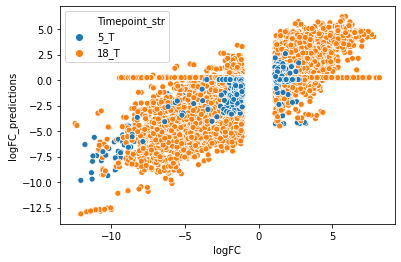

In [24]:
plt.close()
df_pred_observed['Timepoint_str']=df_pred_observed['Timepoint'].apply(str)+'_T'
sns.scatterplot(x='logFC',y='logFC_predictions',
                data=df_pred_observed.loc[df_pred_observed['logFC'].apply(abs)>1.1,:],
               hue='Timepoint_str')

In [26]:
#This is the R2 for genes that are DEGs across all conditions.
from sklearn.metrics import r2_score
r2_score(df_pred_observed.loc[df_pred_observed['logFC'].apply(abs)>1.1,:]['logFC'],
        df_pred_observed.loc[df_pred_observed['logFC'].apply(abs)>1.1,:]['logFC_predictions'])

0.5970686633049525

--------------------------------------------------


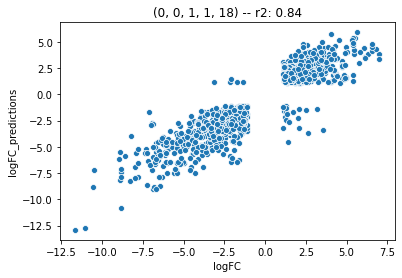

--------------------------------------------------


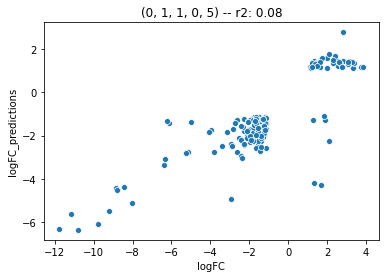

--------------------------------------------------


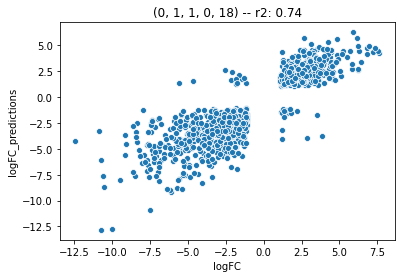

--------------------------------------------------


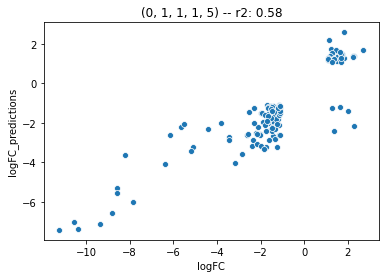

--------------------------------------------------


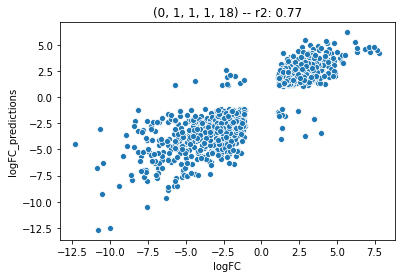

--------------------------------------------------


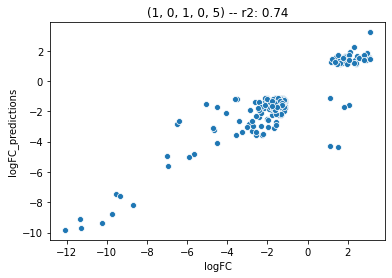

--------------------------------------------------


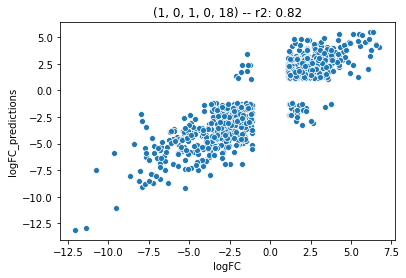

--------------------------------------------------


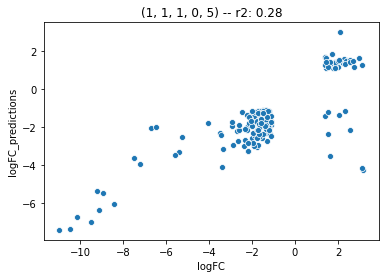

--------------------------------------------------


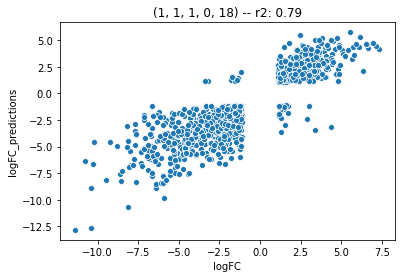

--------------------------------------------------


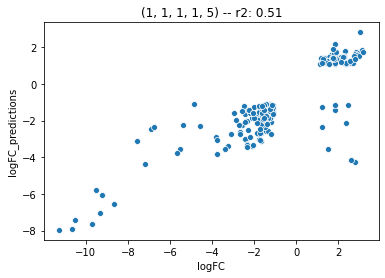

--------------------------------------------------


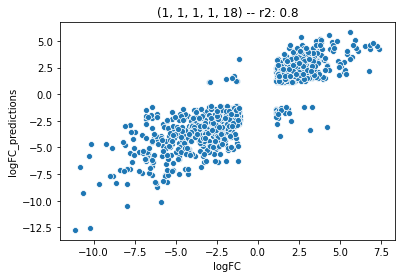

In [31]:
#Iterate through each condition and generate a scatter plot titled with the condition and associated R2 metric for DEGs.
for el in df_pred_observed.groupby(hrm_validation.exp_condition_cols):
    print('-'*50)
    r2 = r2_score(el[1].loc[(el[1]['logFC'].apply(abs)>1.1)&
                                   (el[1]['logFC_predictions'].apply(abs)>1.1),'logFC_predictions'],
                                       el[1].loc[(el[1]['logFC'].apply(abs)>1.1)&
                                   (el[1]['logFC_predictions'].apply(abs)>1.1),'logFC'])
    sns.scatterplot(x='logFC',y='logFC_predictions',
                    data=el[1].loc[(el[1]['logFC'].apply(abs)>1.1)&
                                   (el[1]['logFC_predictions'].apply(
                                       abs)>1.1),:]).set_title(str(el[0]) +' -- r2: '+str(round(r2,2)))
    plt.show()